# Black-Litterman Portfolio

The goal of that notebook is to compute a Black litterman Portfolio on a small universe of tech stocks. The goal is not a proper backtest just a simple implementation.

## <u> Summary :

- [1) Getting Data](#1)
- [2) Mean Variance Weights](#2)
- [3) Market Portfolio](#3)
- [4) Black Litterman](#4)
    - [4.1) CAPM implied expected returns](#4.1)
    - [4.2) Picks](#4.2)
    - [4.3) Conditional parameters](#4.3)
    - [4.4) Results](#4.4)
        - [4.4.1) In Sample test](#4.4.1)
        - [4.4.2) Out of Sample test](#4.4.2)
        - [4.4.3) Retrosepctive on picks](#4.4.3)

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt 

from scipy.optimize import minimize

<a id='1'></a>
### <u> 1. Getting Data

In [2]:
#Set start date and end date.
start_date = '2015-01-01'
end_date = '2022-12-31'

#Set tickers list.
tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'TSLA', 'META']

#Download the monthly prices for those tickers.
prices = yf.download(
    tickers=tickers,
    start=start_date,
    end=end_date,
    interval="1mo"
)['Adj Close']


[*********************100%***********************]  6 of 6 completed


In [3]:
prices.head()

Ticker,AAPL,AMZN,META,MSFT,NVDA,TSLA
Date,,,,,,
2015-01-01 00:00:00+00:00,26.090866,17.726500,75.621140,34.691204,0.460823,13.573333
2015-02-01 00:00:00+00:00,28.607313,19.007999,78.669487,37.653698,0.529466,13.556000
2015-03-01 00:00:00+00:00,27.819216,18.605000,81.907120,35.162914,0.504279,12.584667
2015-04-01 00:00:00+00:00,27.980190,21.089001,78.470245,42.064072,0.534877,15.070000
2015-05-01 00:00:00+00:00,29.127119,21.461500,78.888657,40.524715,0.533191,16.719999


In [4]:
# Count missing values for each ticker
missing_counts = prices.isna().sum()
missing_counts

Ticker
AAPL    0
AMZN    0
META    0
MSFT    0
NVDA    0
TSLA    0
dtype: int64

There is no missing data, no need to do the usual check for missing values

In [5]:
#Set risk free rate equal to 0.
risk_free = 0

#Compute returns and drop the NAN that is generated by the first value :
returns = prices.pct_change().dropna()

returns.head()

Ticker,AAPL,AMZN,META,MSFT,NVDA,TSLA
Date,,,,,,
2015-02-01 00:00:00+00:00,0.096449,0.072293,0.040311,0.085396,0.148959,-0.001277
2015-03-01 00:00:00+00:00,-0.027549,-0.021202,0.041155,-0.066150,-0.047571,-0.071653
2015-04-01 00:00:00+00:00,0.005786,0.133513,-0.041961,0.196262,0.060678,0.197489
2015-05-01 00:00:00+00:00,0.040991,0.017663,0.005332,-0.036596,-0.003153,0.109489
2015-06-01 00:00:00+00:00,-0.033206,0.011323,0.083091,-0.051709,-0.087073,0.069617


<a id='2'></a>
### <u> 2. Mean Variance Weights

In [6]:
def MVP_Weights(returns, risk_free):

    mu = returns.mean()
    V_inv = np.linalg.inv(returns.cov())
    excess_returns = mu - risk_free
    
    # Calculate weights
    weights = V_inv @ excess_returns
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    
    return weights

mvp_weights = pd.DataFrame(MVP_Weights(returns, risk_free), index = returns.columns, columns=['Weights'])
mvp_weights
    

,Weights
Ticker,
AAPL,-0.113633
AMZN,-0.163399
META,-0.202138
MSFT,0.997901
NVDA,0.378651
TSLA,0.102619


These weights are not reasonable to work with, They suggest allocating 99% of our portfolio to MSFT in addition to take very strong short positions in other stocks.

<a id='3'></a>
### <u> 3. Market Portfolio

Rather than getting the current market caps, we design a function that gets us the market caps closest to the start date (in order to not get information we do not have access to in theory when dsigning the portfolio).

In [7]:
def get_historical_market_caps(tickers, date):

    market_caps = pd.DataFrame(columns=['Market_Cap'], index=tickers)

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        
        try:
            # Get historical data around the given date
            history = stock.history(start=date, end=pd.to_datetime(date) + pd.Timedelta(days=5))
            
            # Use the first available trading day's close price
            if not history.empty:
                closing_price = history['Close'].iloc[0]
                shares_outstanding = stock.info.get('sharesOutstanding')

                if closing_price and shares_outstanding:
                    market_cap = closing_price * shares_outstanding #Market cap = closing price x num_shares
                    market_caps.loc[ticker, 'Market_Cap'] = market_cap
                else:
                    market_caps.loc[ticker, 'Market_Cap'] = None
            else:
                market_caps.loc[ticker, 'Market_Cap'] = None

        except Exception as e:
            print(f"Error retrieving data for {ticker}: {e}")
            market_caps.loc[ticker, 'Market_Cap'] = None

    return market_caps.T

market_caps = get_historical_market_caps(tickers, start_date)
market_caps = market_caps.reindex(sorted(market_caps.columns), axis=1)
market_caps


,AAPL,AMZN,META,MSFT,NVDA,TSLA
Market_Cap,366130329108.535156,162204391165.834961,171143898703.697266,298492765796.164062,11832184707.083008,47027668354.934326


In [8]:
Mkt_Weights = market_caps.T / np.sum(market_caps.T)

Mkt_Weights = Mkt_Weights.squeeze() #type conversion to not break the code

print(Mkt_Weights)

AAPL    0.346442
AMZN    0.153482
META    0.161941
MSFT    0.282441
NVDA    0.011196
TSLA    0.044499
Name: Market_Cap, dtype: object


<a id='4'></a>
### <u> 4. Black-Litterman

<a id='4.1'></a>
#### <u> 4.1 CAPM-implied expected returns

In [9]:
def compute_CAPM_rets(rf,rets,mkt_w):
    ones=np.ones(len(rets.columns))
    V= rets.cov()
    Var_mkt= mkt_w.transpose().dot(V).dot(mkt_w)
    SR_mkt= rets.dot(mkt_w).mean() / np.sqrt(Var_mkt)
    E_capm=rf*ones+(SR_mkt/np.sqrt(Var_mkt))*V.dot(mkt_w)
    return(E_capm)

E_Mkt_returns = compute_CAPM_rets(risk_free, returns, Mkt_Weights)
E_Mkt_returns

Ticker
AAPL    0.021991
AMZN     0.02175
META    0.018779
MSFT    0.015865
NVDA    0.026025
TSLA     0.03365
dtype: object

<a id='4.2'></a>
#### <u> 4.2 Picks

We Specify the pick matrix P and the view vector q that captures the following views for each of the assets (these views are absolutely arbitrary):
    
* AAPL: its absolute excess return is expected to be 10% per year. 
* MSFT: its absolute excess return is expected to be 5% per year.
* AMZN: no views
* NVDA will outperform TSLA by 2% per year.
* TSLA will underperform META by 1% per year.

In [10]:
P = np.array([
    [1, 0, 0, 0, 0, 0],   # AAPL's absolute excess return view
    [0, 0, 0, 1, 0, 0],   # MSFT's absolute excess return view
    [0, 0, 0, 0, 1, -1],  # NVDA expected to outperform TSLA by 2%
    [0, 0, 1, 0, 0, -1]   # META expected to outperform TSLA by 1%
])

q = np.array([0.10, 0.05, 0.02, 0.01])

# Set the confidence level tau
tau = 0.05

# Calculate the uncertainty for each view
view_uncertainties = []

for k in range(P.shape[0]):  # Loop through each view (rows of P)
    P_k = P[k, :].reshape(1, -1)  # Make it a 1x6 row vector
    # Compute P_k * tau * Sigma * P_k.T
    uncertainty = P_k @ (tau * returns.cov()) @ P_k.T
    view_uncertainties.append(uncertainty)

Omega = np.diagflat(np.array(view_uncertainties))

### Nice display : 

P_df = pd.DataFrame(P, columns=E_Mkt_returns.index)
q_df = pd.DataFrame(q, columns=['View Returns'], index=[f'View {i+1}' for i in range(len(q))])
Omega_df = pd.DataFrame(Omega, columns=[f'View {i+1}' for i in range(Omega.shape[0])], 
                        index=[f'View {i+1}' for i in range(Omega.shape[0])])

print("P (view matrix):")
print(P_df, '\n')
print("Q (view returns):")
print(q_df, '\n')
print("Omega (view uncertainties):")
print(Omega_df, '\n')

P (view matrix):
Ticker  AAPL  AMZN  META  MSFT  NVDA  TSLA
0          1     0     0     0     0     0
1          0     0     0     1     0     0
2          0     0     0     0     1    -1
3          0     0     1     0     0    -1 

Q (view returns):
        View Returns
View 1          0.10
View 2          0.05
View 3          0.02
View 4          0.01 

Omega (view uncertainties):
          View 1    View 2    View 3    View 4
View 1  0.000354  0.000000  0.000000  0.000000
View 2  0.000000  0.000199  0.000000  0.000000
View 3  0.000000  0.000000  0.001784  0.000000
View 4  0.000000  0.000000  0.000000  0.001647 



**Choice of Omega :**

In the Black-Litterman model, the uncertainty associated with each view is captured in the diagonal matrix $\Omega$. Instead of assigning arbitrary or fixed values for uncertainties, we use a **proportional uncertainty approach** that derives $\Omega$ based on the covariance structure of asset returns and the nature of each view. This approach ensures that the uncertainty reflects the underlying risk dynamics of the market and is mathematically consistent with the model’s assumptions.


For a given view $k$, the uncertainty is computed as:

$$
\text{Uncertainty}_k = P_k (\tau \Sigma) P_k^T
$$

Where:
- $P_k$ is the $k$-th row of the view matrix $P$ (a $1 \times N$ vector for $N$ assets).
- $\tau$ is a scalar controlling the relative weight of the prior covariance matrix $\Sigma$.
- $\Sigma$ is the covariance matrix of asset returns.

The result is a scalar value representing the uncertainty (variance) associated with view $k$. The diagonal matrix $\Omega$ is then constructed using these computed uncertainties:

$$
\Omega = \text{diag}(\text{Uncertainty}_1, \text{Uncertainty}_2, \dots, \text{Uncertainty}_K)
$$


- **Dynamic and Contextual**  
   This method adjusts the uncertainty for each view based on:
   - The volatility and correlations of the assets involved in the view (captured by $\Sigma$).
   - The structure of the view itself (captured by $P$).  
   As a result, views on highly volatile or correlated assets naturally have larger uncertainties, while more stable views exhibit smaller uncertainties.

- **Objective Estimation**  
   This method eliminates subjectivity in choosing $\Omega$ and relies entirely on observable market data. It ensures that the uncertainty reflects measurable characteristics like volatility and correlations.

- **Risk-Adjusted Confidence**  
   The proportional uncertainty technique allows for **confidence-weighted views**, where the model respects both the prior (market equilibrium) and the expressed views in proportion to their inherent risk.


Using this method for calculating $\Omega$ provides a mathematically robust and market-driven approach to incorporating uncertainty into the Black-Litterman model. It avoids arbitrary assumptions and ensures that the model respects the market's covariance structure and the nature of the views.


<a id='4.3'></a>
#### <u> 4.3 Conditional Parameters

In [11]:
# Define nice variables for readability
mu_CAPM = E_Mkt_returns  # Market-implied expected returns
sigma = returns.cov()    # Covariance matrix of asset returns

# Compute Black-Litterman Expected Returns (mu_BL)
term1 = np.linalg.inv(P @ (tau * sigma) @ P.T + Omega)
term2 = P @ (tau * sigma) @ mu_CAPM
mu_BL = mu_CAPM + term2 @ term1 @ (q - term2)

# Calculate the conditional covariance (variance) of expected returns
tau_Sigma_inv = np.linalg.inv(tau * sigma)
conditional_variance = np.linalg.inv(tau_Sigma_inv + P.T @ np.linalg.inv(Omega) @ P)

# Compute the posterior covariance matrix (Black-Litterman covariance)
BL_cov = sigma + conditional_variance

# Displays : 

print("\nBlack-Litterman Expected Returns:")
mu_BL_df = pd.DataFrame(mu_BL, index=returns.columns, columns=["Expected Returns"])
print(mu_BL_df)

print("\nSigma:")
sigma_df = pd.DataFrame(sigma, index=returns.columns, columns=returns.columns)
print(round(sigma_df, 5))

print("\nAdjustments (Conditional Variance):")
conditional_variance_df = pd.DataFrame(conditional_variance, index=returns.columns, columns=returns.columns)
print(round(conditional_variance_df, 5))

print("\nBlack-Litterman Covariance Matrix:")
BL_cov_df = pd.DataFrame(BL_cov, index=returns.columns, columns=returns.columns)
print(round(BL_cov_df, 5))



Black-Litterman Expected Returns:
       Expected Returns
Ticker                 
AAPL            0.02839
AMZN           0.028148
META           0.025177
MSFT           0.022263
NVDA           0.032423
TSLA           0.040049

Sigma:
Ticker     AAPL     AMZN     META     MSFT     NVDA     TSLA
Ticker                                                      
AAPL    0.00708  0.00419  0.00320  0.00326  0.00642  0.00815
AMZN    0.00419  0.00842  0.00414  0.00393  0.00649  0.00716
META    0.00320  0.00414  0.00904  0.00279  0.00439  0.00455
MSFT    0.00326  0.00393  0.00279  0.00399  0.00499  0.00493
NVDA    0.00642  0.00649  0.00439  0.00499  0.01791  0.00762
TSLA    0.00815  0.00716  0.00455  0.00493  0.00762  0.03300

Adjustments (Conditional Variance):
Ticker     AAPL     AMZN     META     MSFT     NVDA     TSLA
Ticker                                                      
AAPL    0.00015  0.00007  0.00007  0.00004  0.00012  0.00012
AMZN    0.00007  0.00030  0.00012  0.00008  0.00016  0.00

<a id='4.4'></a>
#### <u> 4.4 Results

In [12]:
Rf = np.ones(len(mu_BL)) * risk_free
weights_BL = np.linalg.inv(BL_cov) @ (mu_BL - Rf)
weights_BL /= np.sum(weights_BL)

bl_weights = pd.DataFrame(weights_BL, index = mu_BL_df.index, columns = ['BL Weights'] )
bl_weights

,BL Weights
Ticker,
AAPL,0.318039
AMZN,0.102767
META,0.151893
MSFT,0.443707
NVDA,-0.028699
TSLA,0.012293


<a id='4.4.1'></a>
##### <u> 4.4.1 In-Sample test

In [13]:
weights_comparison = pd.concat([bl_weights, mvp_weights, Mkt_Weights], axis=1)
weights_comparison.columns = ['Black-Litterman', 'MVP', 'Market']

weights_comparison

,Black-Litterman,MVP,Market
AAPL,0.318039,-0.113633,0.346442
AMZN,0.102767,-0.163399,0.153482
META,0.151893,-0.202138,0.161941
MSFT,0.443707,0.997901,0.282441
NVDA,-0.028699,0.378651,0.011196
TSLA,0.012293,0.102619,0.044499


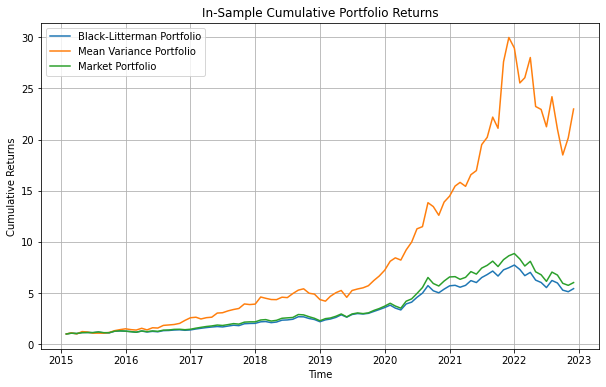

In [14]:
# Calculate portfolio returns by multiplying asset returns with portfolio weights
bl_returns = returns.dot(bl_weights)
mvp_returns = returns.dot(mvp_weights) 
mkt_returns = returns.dot(Mkt_Weights)  

bl_cumulative_returns = (1 + bl_returns).cumprod().shift(1, fill_value=1)
mvp_cumulative_returns = (1 + mvp_returns).cumprod().shift(1, fill_value=1)
mkt_cumulative_returns = (1 + mkt_returns).cumprod().shift(1, fill_value=1)

# NVDA Returns What the ... ?
#nvda_returns = returns['MSFT']
#nvda_cumulative_returns = (1 + nvda_returns).cumprod().shift(1, fill_value=1)

# Plot portfolio cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(bl_cumulative_returns, label="Black-Litterman Portfolio")
plt.plot(mvp_cumulative_returns, label="Mean Variance Portfolio")
plt.plot(mkt_cumulative_returns, label="Market Portfolio")
#plt.plot(nvda_cumulative_returns, label="MSFT", linestyle = 'dashed')
plt.title('In-Sample Cumulative Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

There is so much overlap between the black-Litterman and the market portfolio that we can't see the difference,we can see that the MVP also performs way better than the other two, due to massive risk taken in its positions. Note that this is in sample so the testing is biased in that way.

we try to plot BL/Market alone to see the difference clearer: 

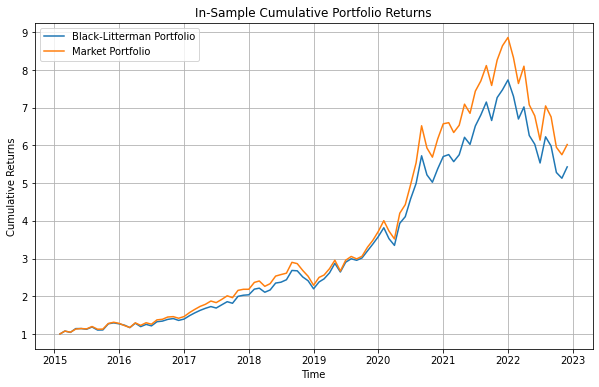

In [15]:
# Plot portfolio cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(bl_cumulative_returns, label="Black-Litterman Portfolio")
plt.plot(mkt_cumulative_returns, label="Market Portfolio")
#plt.plot(nvda_cumulative_returns, label="MSFT", linestyle = 'dashed')
plt.title('In-Sample Cumulative Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

We can see that the BL portfolio gets beaten by the market in a cumulative returns perspective.

In [16]:
sharpe_bl = (bl_returns.mean()/bl_returns.std()).iloc[0] #To convert to float
sharpe_mvp = (mvp_returns.mean()/mvp_returns.std()).iloc[0] #To convert to float
sharpe_mkt = mkt_returns.mean()/mkt_returns.std() #already a float

print('Sharpe ratios (In-Sample)\n')
print('Black-Litterman :')
print(sharpe_bl)
print('MVP :')
print(sharpe_mvp)
print('Market :')
print(sharpe_mkt)

Sharpe ratios (In-Sample)

Black-Litterman :
0.301465055225363
MVP :
0.40862707738718346
Market :
0.29945794177948154


In Sample, the best performer is the MVP, due to wild positions in MSFT that paid off. The black litterman portfolio also outperformed the market portfolio probably because the views that we made for the BL reduced the risk (volatility) more than the market portfolio was able to keep its returns.

<a id='4.4.2'></a>
##### <u> 4.4.2 Out-of-Sample test

We decide to test out of sample on the next year (actually almost the last reported montly return) to better capture the efficiency of each portfolio.

In [17]:
#Set start date and end date
start_date_OOS = '2022-11-30'
end_date_OOS = '2024-08-31'

#Set tickers list
tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'TSLA', 'META']

#Download the monthly prices for those tickers, as well as their market capitalization
prices_OOS = yf.download(
    tickers=tickers,
    start=start_date_OOS,
    end=end_date_OOS,
    interval="1mo"
)['Adj Close']

returns_OOS = prices_OOS.pct_change().dropna()
returns_OOS



[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,AMZN,META,MSFT,NVDA,TSLA
Date,,,,,,
2023-01-01 00:00:00+00:00,0.110521,0.227738,0.237909,0.033317,0.336869,0.406235
2023-02-01 00:00:00+00:00,0.021623,-0.086299,0.174330,0.006497,0.188309,0.187565
2023-03-01 00:00:00+00:00,0.120357,0.096148,0.211501,0.158777,0.196459,0.008507
2023-04-01 00:00:00+00:00,0.028987,0.020912,0.133906,0.065765,-0.000838,-0.207992
2023-05-01 00:00:00+00:00,0.044613,0.143480,0.101531,0.068769,0.363436,0.241130
2023-06-01 00:00:00+00:00,0.095844,0.081108,0.084089,0.039266,0.118095,0.283627
2023-07-01 00:00:00+00:00,0.012785,0.025468,0.110182,-0.013567,0.104767,0.021622
2023-08-01 00:00:00+00:00,-0.043675,0.032391,-0.071281,-0.024292,0.056196,-0.034962
2023-09-01 00:00:00+00:00,-0.087448,-0.078907,0.014600,-0.034603,-0.118651,-0.030456


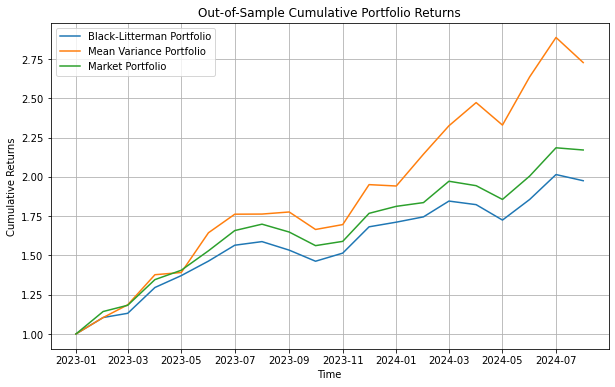

In [18]:
# Calculate portfolio returns by multiplying asset returns with portfolio weights
bl_returns_OOS = returns_OOS.dot(bl_weights)
mvp_returns_OOS = returns_OOS.dot(mvp_weights) 
mkt_returns_OOS = returns_OOS.dot(Mkt_Weights)  

# Calculate cumulative returns and shift to start from 1
bl_cumulative_returns_OOS = (1 + bl_returns_OOS).cumprod().shift(1, fill_value=1)
mvp_cumulative_returns_OOS = (1 + mvp_returns_OOS).cumprod().shift(1, fill_value=1)
mkt_cumulative_returns_OOS = (1 + mkt_returns_OOS).cumprod().shift(1, fill_value=1)

# NVDA Returns What the ... ?
# nvda_returns_OOS = returns_OOS['NVDA']
# nvda_cumulative_returns_OOS = (1 + nvda_returns_OOS).cumprod().shift(1, fill_value=1)

# Plot portfolio cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(bl_cumulative_returns_OOS, label="Black-Litterman Portfolio")
plt.plot(mvp_cumulative_returns_OOS, label="Mean Variance Portfolio")
plt.plot(mkt_cumulative_returns_OOS, label="Market Portfolio")
#plt.plot(nvda_cumulative_returns_OOS, label="NVDA", linestyle = 'dashed')
plt.title('Out-of-Sample Cumulative Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

We can see that, out of sample, the mean variance portfolio is still the best performer in cumulative returns.
The Market portfolio is closely followed by the BL just like in the In-Sample case.

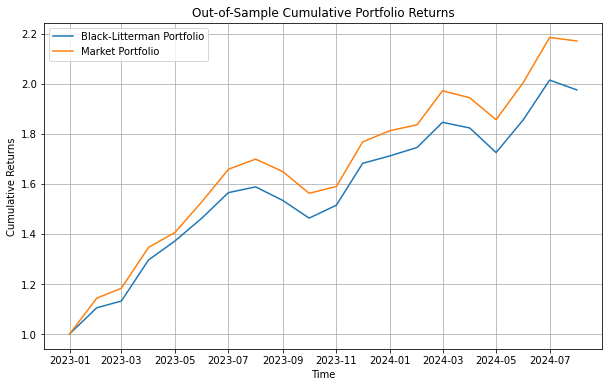

In [19]:
# Plot portfolio cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(bl_cumulative_returns_OOS, label="Black-Litterman Portfolio")
plt.plot(mkt_cumulative_returns_OOS, label="Market Portfolio")
#plt.plot(nvda_cumulative_returns_OOS, label="NVDA", linestyle = 'dashed')
plt.title('Out-of-Sample Cumulative Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
sharpe_bl_OOS = (bl_returns_OOS.mean()/bl_returns_OOS.std()).iloc[0] #To convert to float
sharpe_mvp_OOS = (mvp_returns_OOS.mean()/mvp_returns_OOS.std()).iloc[0] #To convert to float
sharpe_mkt_OOS = mkt_returns_OOS.mean()/mkt_returns_OOS.std() #already a float

print('Sharpe ratios (Out-of-Sample) :\n')

print('Black-Litterman :')
print(sharpe_bl_OOS)
print('MVP :')
print(sharpe_mvp_OOS)
print('Market :')
print(sharpe_mkt_OOS)

print('\nDifference mkt - BL:')
print(sharpe_mkt_OOS - sharpe_bl_OOS)

Sharpe ratios (Out-of-Sample) :

Black-Litterman :
0.679262610695005
MVP :
0.7068850898355944
Market :
0.7269081503351924

Difference mkt - BL:
0.04764553964018736


We can see that, out of sample The Market becomes the best performer. Closely followed by the MVP, then by the BLack-Litterman portfolio.

* The over performance of the MVP is probably due to its wild positions and the fact that they paid out (especially NVDA and MSFT, see our analysis below).
* This sub performance of the MVP is probably due to our views that didn't realize as much as we wish they would have: 3 out of the 4 turned out the be losing (see out analysis below).

<a id='4.4.3'></a>
##### <u> 4.4.3 Retrospective on picks


Stock Contributions to MVP Cumulative Returns:
       Stock  Final Contribution (%)  Cumulative Return
Ticker                                                 
NVDA    NVDA               85.868523           3.094666
MSFT    MSFT               48.766678           1.757531
TSLA    TSLA                4.949289           0.178370
AAPL    AAPL               -5.602910          -0.201927
AMZN    AMZN               -9.634510          -0.347224
META    META              -24.347070          -0.877458


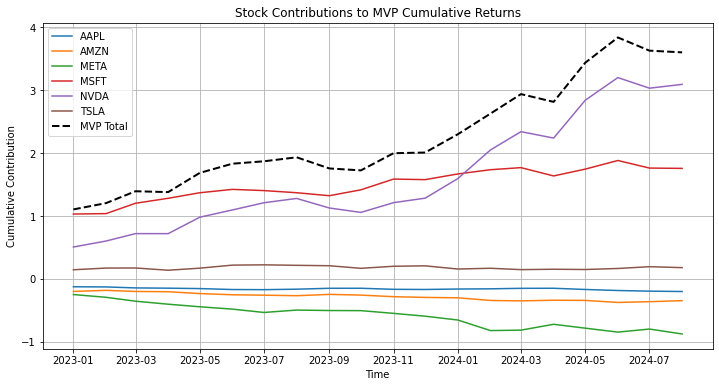

In [21]:
# Calculate cumulative returns for individual stocks
cumulative_returns_stocks = (1 + returns_OOS).cumprod()

# Multiply cumulative returns by the MVP weights to get contributions
stock_contributions = cumulative_returns_stocks * mvp_weights['Weights']

# Calculate the cumulative MVP return for validation
mvp_cumulative_returns_OOS = stock_contributions.sum(axis=1)

# Normalize contributions by total MVP return to get percentage contributions
total_mvp_return = mvp_cumulative_returns_OOS.iloc[-1]  # Total MVP return at the end
stock_contributions_percent = stock_contributions.iloc[-1] / total_mvp_return * 100

# Summarize results
contribution_summary = pd.DataFrame({
    'Stock': stock_contributions.columns,
    'Final Contribution (%)': stock_contributions_percent,
    'Cumulative Return': stock_contributions.iloc[-1]
}).sort_values(by='Final Contribution (%)', ascending=False)

# Display the contributions
print("\nStock Contributions to MVP Cumulative Returns:")
print(contribution_summary)

# Plot the contributions over time

plt.figure(figsize=(12, 6))
for stock in stock_contributions.columns:
    plt.plot(stock_contributions.index, stock_contributions[stock], label=stock)
plt.plot(mvp_cumulative_returns_OOS, label='MVP Total', color='black', linewidth=2, linestyle='--')

plt.title('Stock Contributions to MVP Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Contribution')
plt.legend()
plt.grid()
plt.show()


In [22]:
realized_returns = returns_OOS[tickers].mean()  # Average realized OOS returns
realized_views = P @ realized_returns.values

# Create a DataFrame to summarize results
results = pd.DataFrame({
    'Assumption': q,
    'Realized': realized_views,
    'Difference': realized_views - q
}, index=['AAPL Excess Return', 'MSFT Excess Return', 'NVDA vs TSLA', 'META vs TSLA'])

# Display the results
print("\nComparison of Assumptions and Realized Returns:")
print(results)



Comparison of Assumptions and Realized Returns:
                    Assumption  Realized  Difference
AAPL Excess Return        0.10  0.031038   -0.068962
MSFT Excess Return        0.05  0.118890    0.068890
NVDA vs TSLA              0.02 -0.038932   -0.058932
META vs TSLA              0.01 -0.039336   -0.049336
